In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import pickle
from pprint import pprint
from collections import Counter
from transformers import AutoTokenizer

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained(
    'TinyLlama/TinyLlama-1.1B-Chat-v1.0',
    model_max_length=512,
    padding_side='left',
    trust_remote_code=True,
    use_fast=False,
)

/home/chalbeise/miniconda3/envs/mcts-dpo/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
def get_name(node):
    name = '<s>' if not node.depth else tokenizer.decode(node.action)
    name = name.replace('\\', '/')
    text = '[{}] {}'.format(node.N, name)
    tokens = text.split()
    num_per_line = (int(len(tokens) ** .5) + 1)# * 2
    line_cnt = (len(tokens) + num_per_line - 1) // num_per_line
    name = '\n'.join(' '.join(tokens[i*num_per_line: (i+1)*num_per_line]) for i in range(line_cnt))
    try:
        p = node.p
    except:
        p = 1
    # return name + '\n(Q: {:.5f}) (P: {:.5f}) (R: {:.5f})'.format(node.Q, p, np.exp(node.reward))
    return name + '\n(Q: {:.5f}) (P: {:.5f}) (V: {:.5f})'.format(node.Q if node.Q is not None else -1, p, node.V)

def add_edges_with_path(graph, node, parent_name, path):
    child_name = get_name(node)
    if node in path:
        graph.add_edge(parent_name, child_name, color = "red")
        graph.nodes[parent_name]['color'] = 'red'
        graph.nodes[child_name]['color'] = 'red'
    else:
        graph.add_edge(parent_name, child_name, color = "blue")
        graph.nodes[parent_name]['color'] = 'blue'
        graph.nodes[child_name]['color'] = 'blue'
    v = node.children
    if v is not None:
        for vv in v:
            if vv.N:
                add_edges_with_path(graph, vv, child_name, path)

def draw_tree_with_path(tree, path, fig=None, ax=None):
    graph = nx.DiGraph()
    k = get_name(tree)
    if tree in path:
        graph.add_node(k, color = "red")
    else:
        graph.add_node(k, color = "blue")
    v = tree.children
    if v is not None:
        for vv in v:
            add_edges_with_path(graph, vv, k, path)    
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use the pygraphviz layout for horizontal tree structure
    pos = nx.nx_agraph.graphviz_layout(graph, prog='dot', args='-Grankdir=LR')
    node_colors = [graph.nodes[n].get('color', 'blue') for n in graph.nodes]
    edge_colors = [graph[u][v].get('color', 'blue') for u, v in graph.edges]
    nx.draw(graph, pos, with_labels=True, arrows=False, ax=ax, font_size=18, node_color=node_colors, edge_color=edge_colors)
    ax.set_title("Tree Visualization")
    fig.set_facecolor("w")
    fig.subplots_adjust(left=-0.05, right=1.00, top=1.01, bottom=.01)
    # fig.savefig(save_pth, format='pdf')
    plt.show()

In [7]:
def visualize_iteration_tree(output_path, iteration):
    output_path = f'{output_path}/{iteration}'
    for file in sorted(os.listdir(output_path)):
        print(file)
        with open(f'{output_path}/{file}', 'rb') as f:
            dump_data = pickle.load(f)
        cur_node = dump_data['cur_node']
        path = dump_data['path']
        while cur_node.depth:
            cur_node = cur_node.parent
        root = cur_node
        fig, ax = plt.subplots(figsize=(30, 20))
        draw_tree_with_path(root, path, fig, ax)

## Iteration 1

mcts_rst_0.pkl
[2025-06-23 18:36:38,591] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/chalbeise/miniconda3/envs/mcts-dpo/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/chalbeise/miniconda3/envs/mcts-dpo/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


[2025-06-23 18:36:40,102] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


/home/chalbeise/miniconda3/envs/mcts-dpo/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


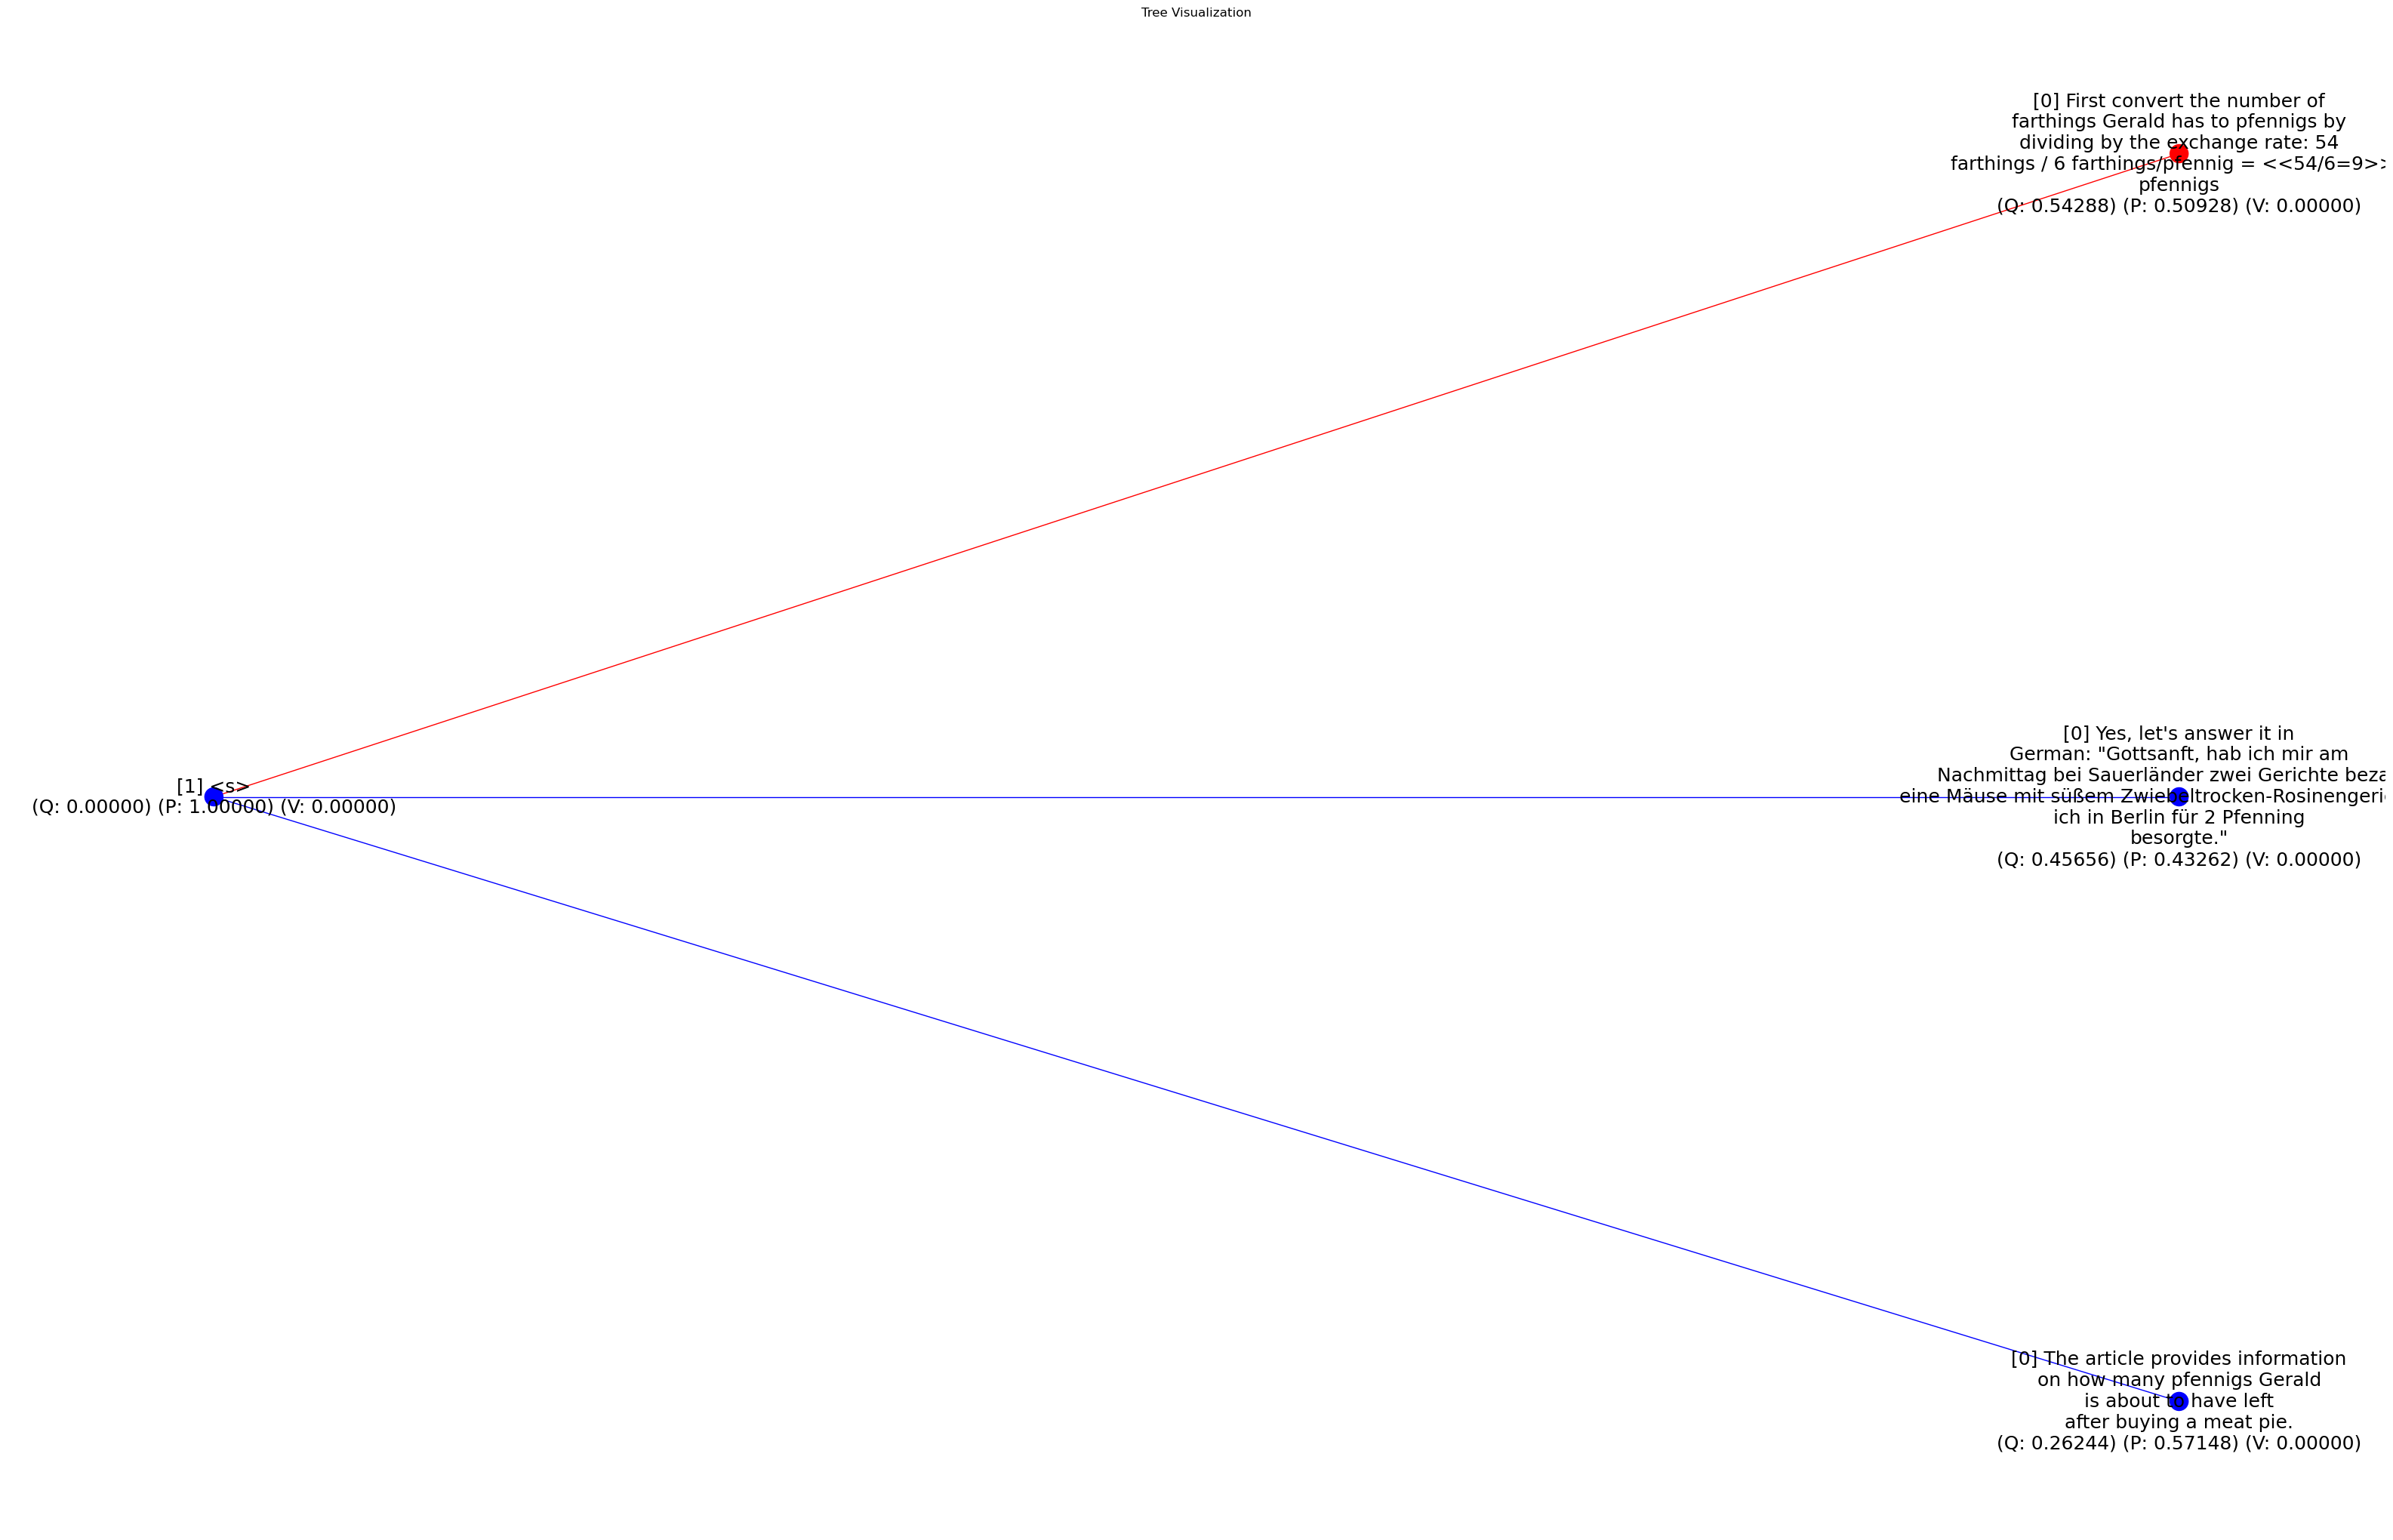

mcts_rst_1.pkl


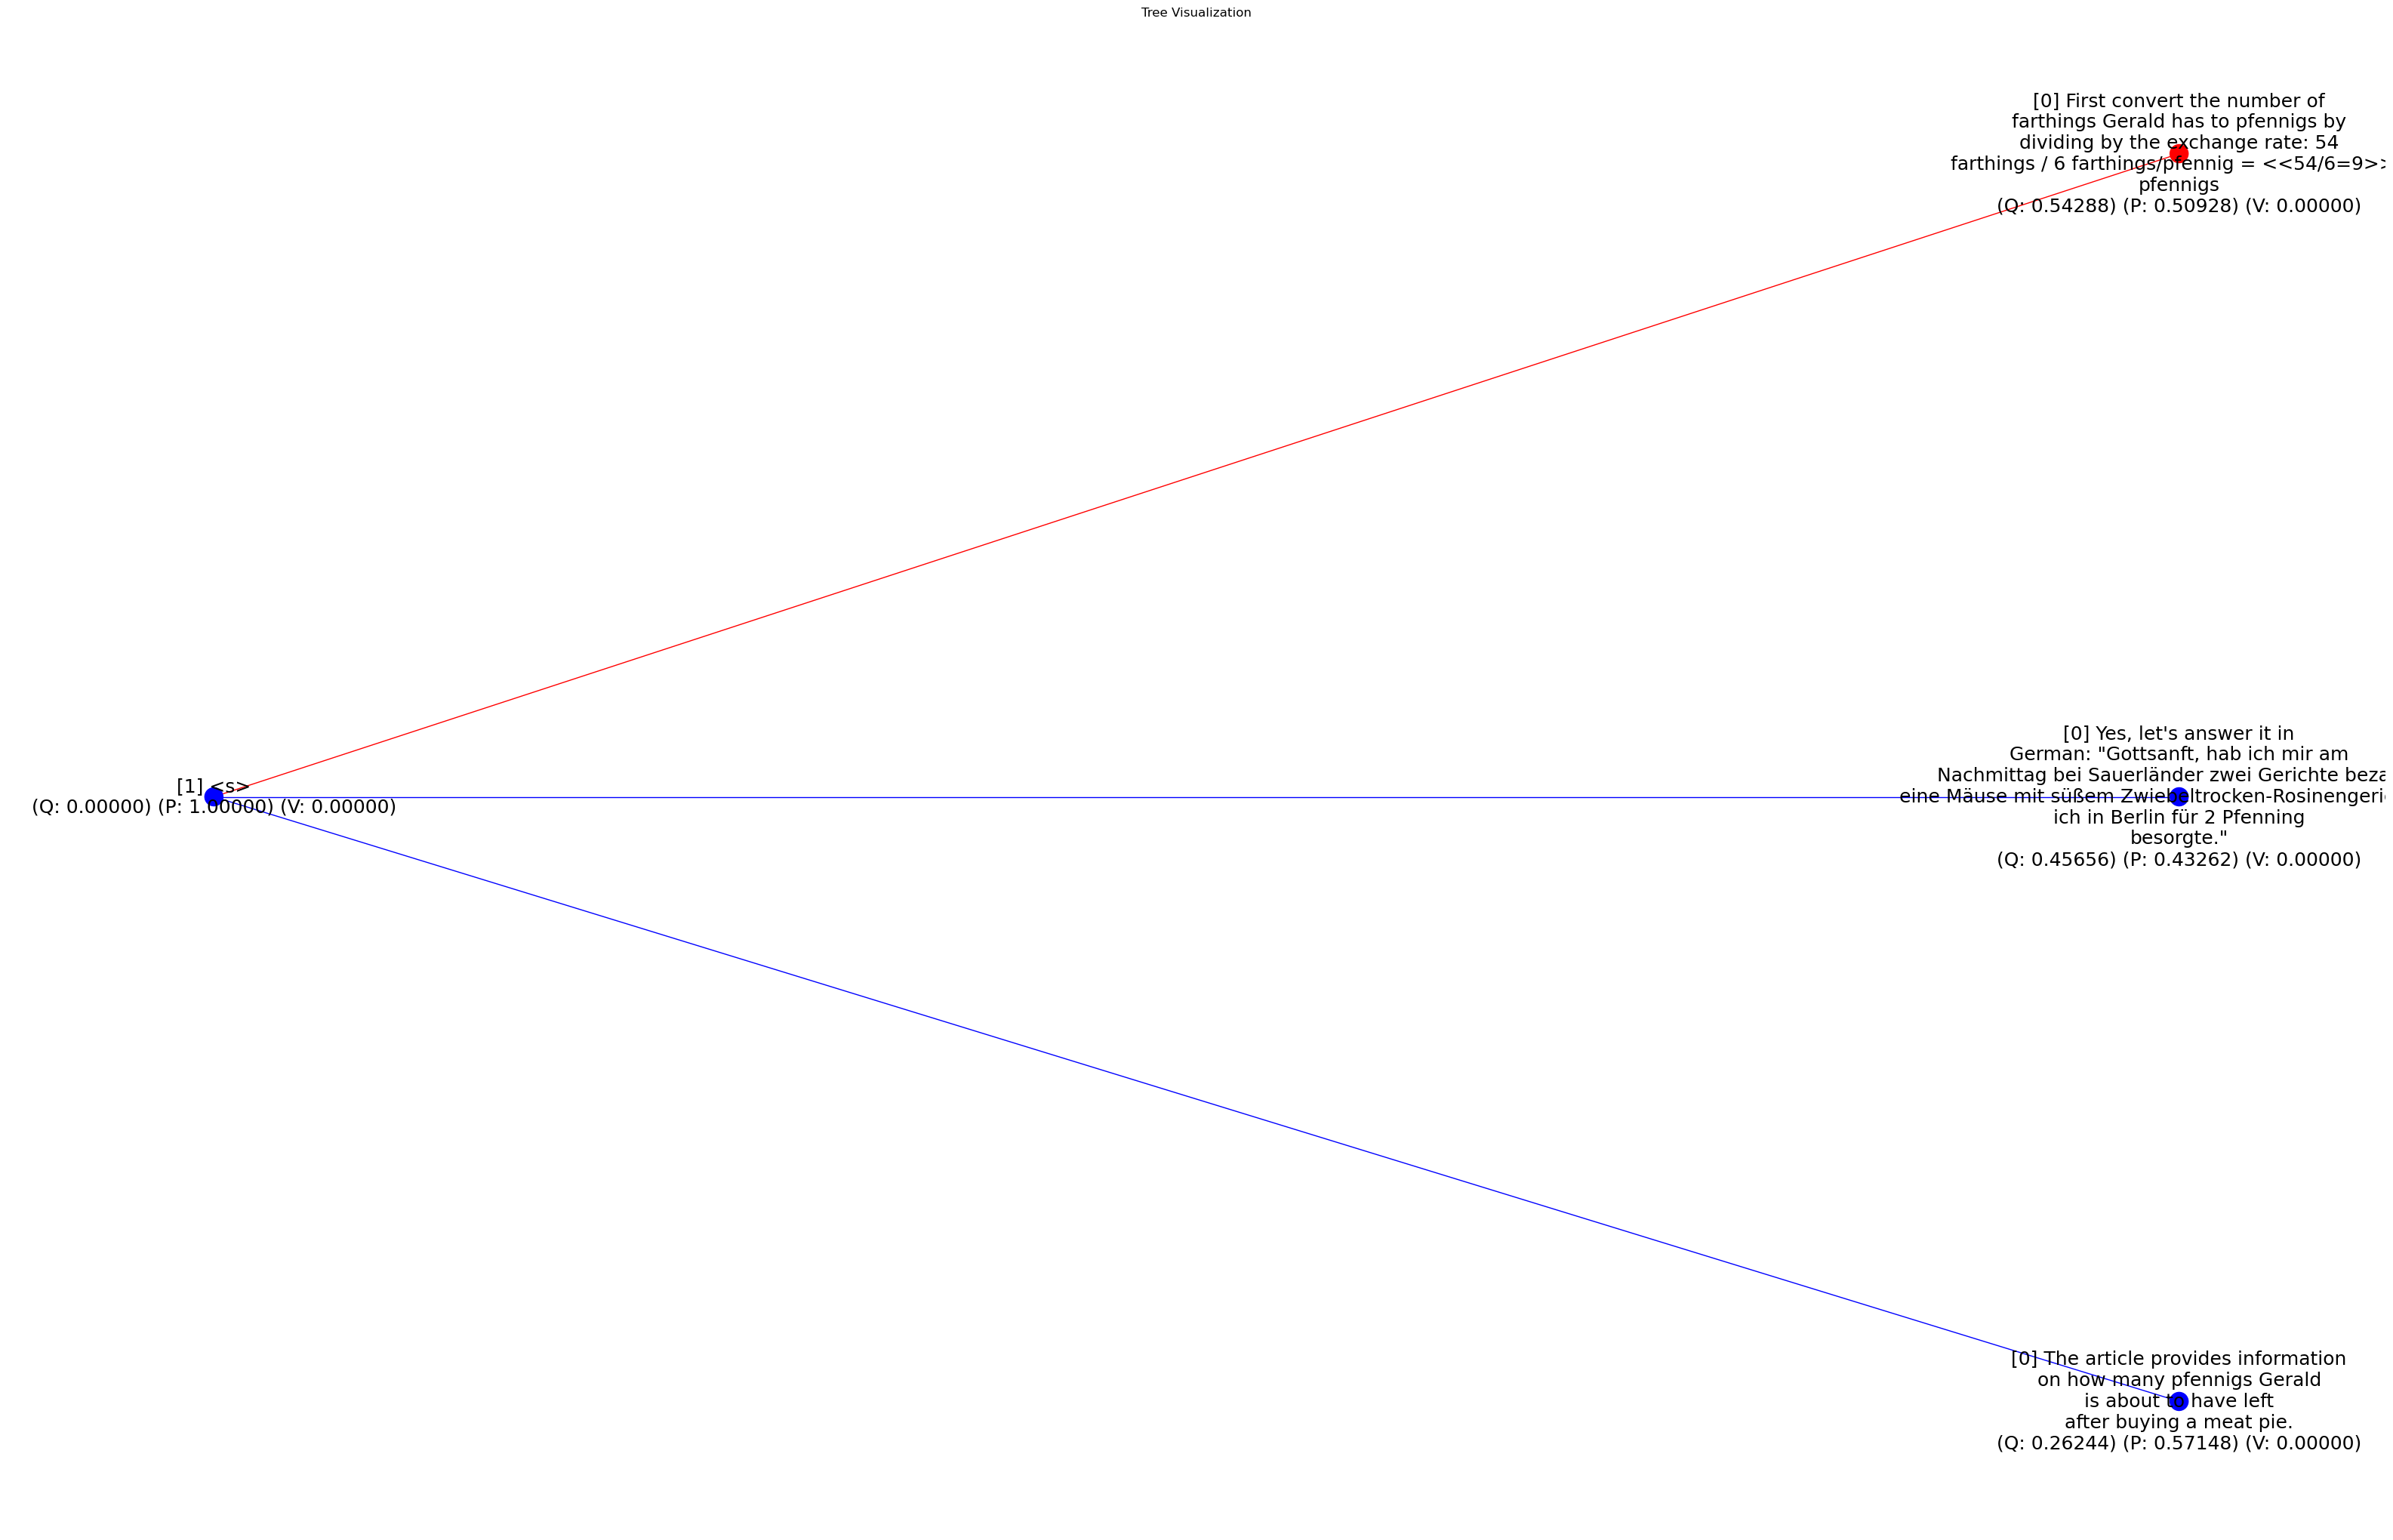

mcts_rst_2.pkl


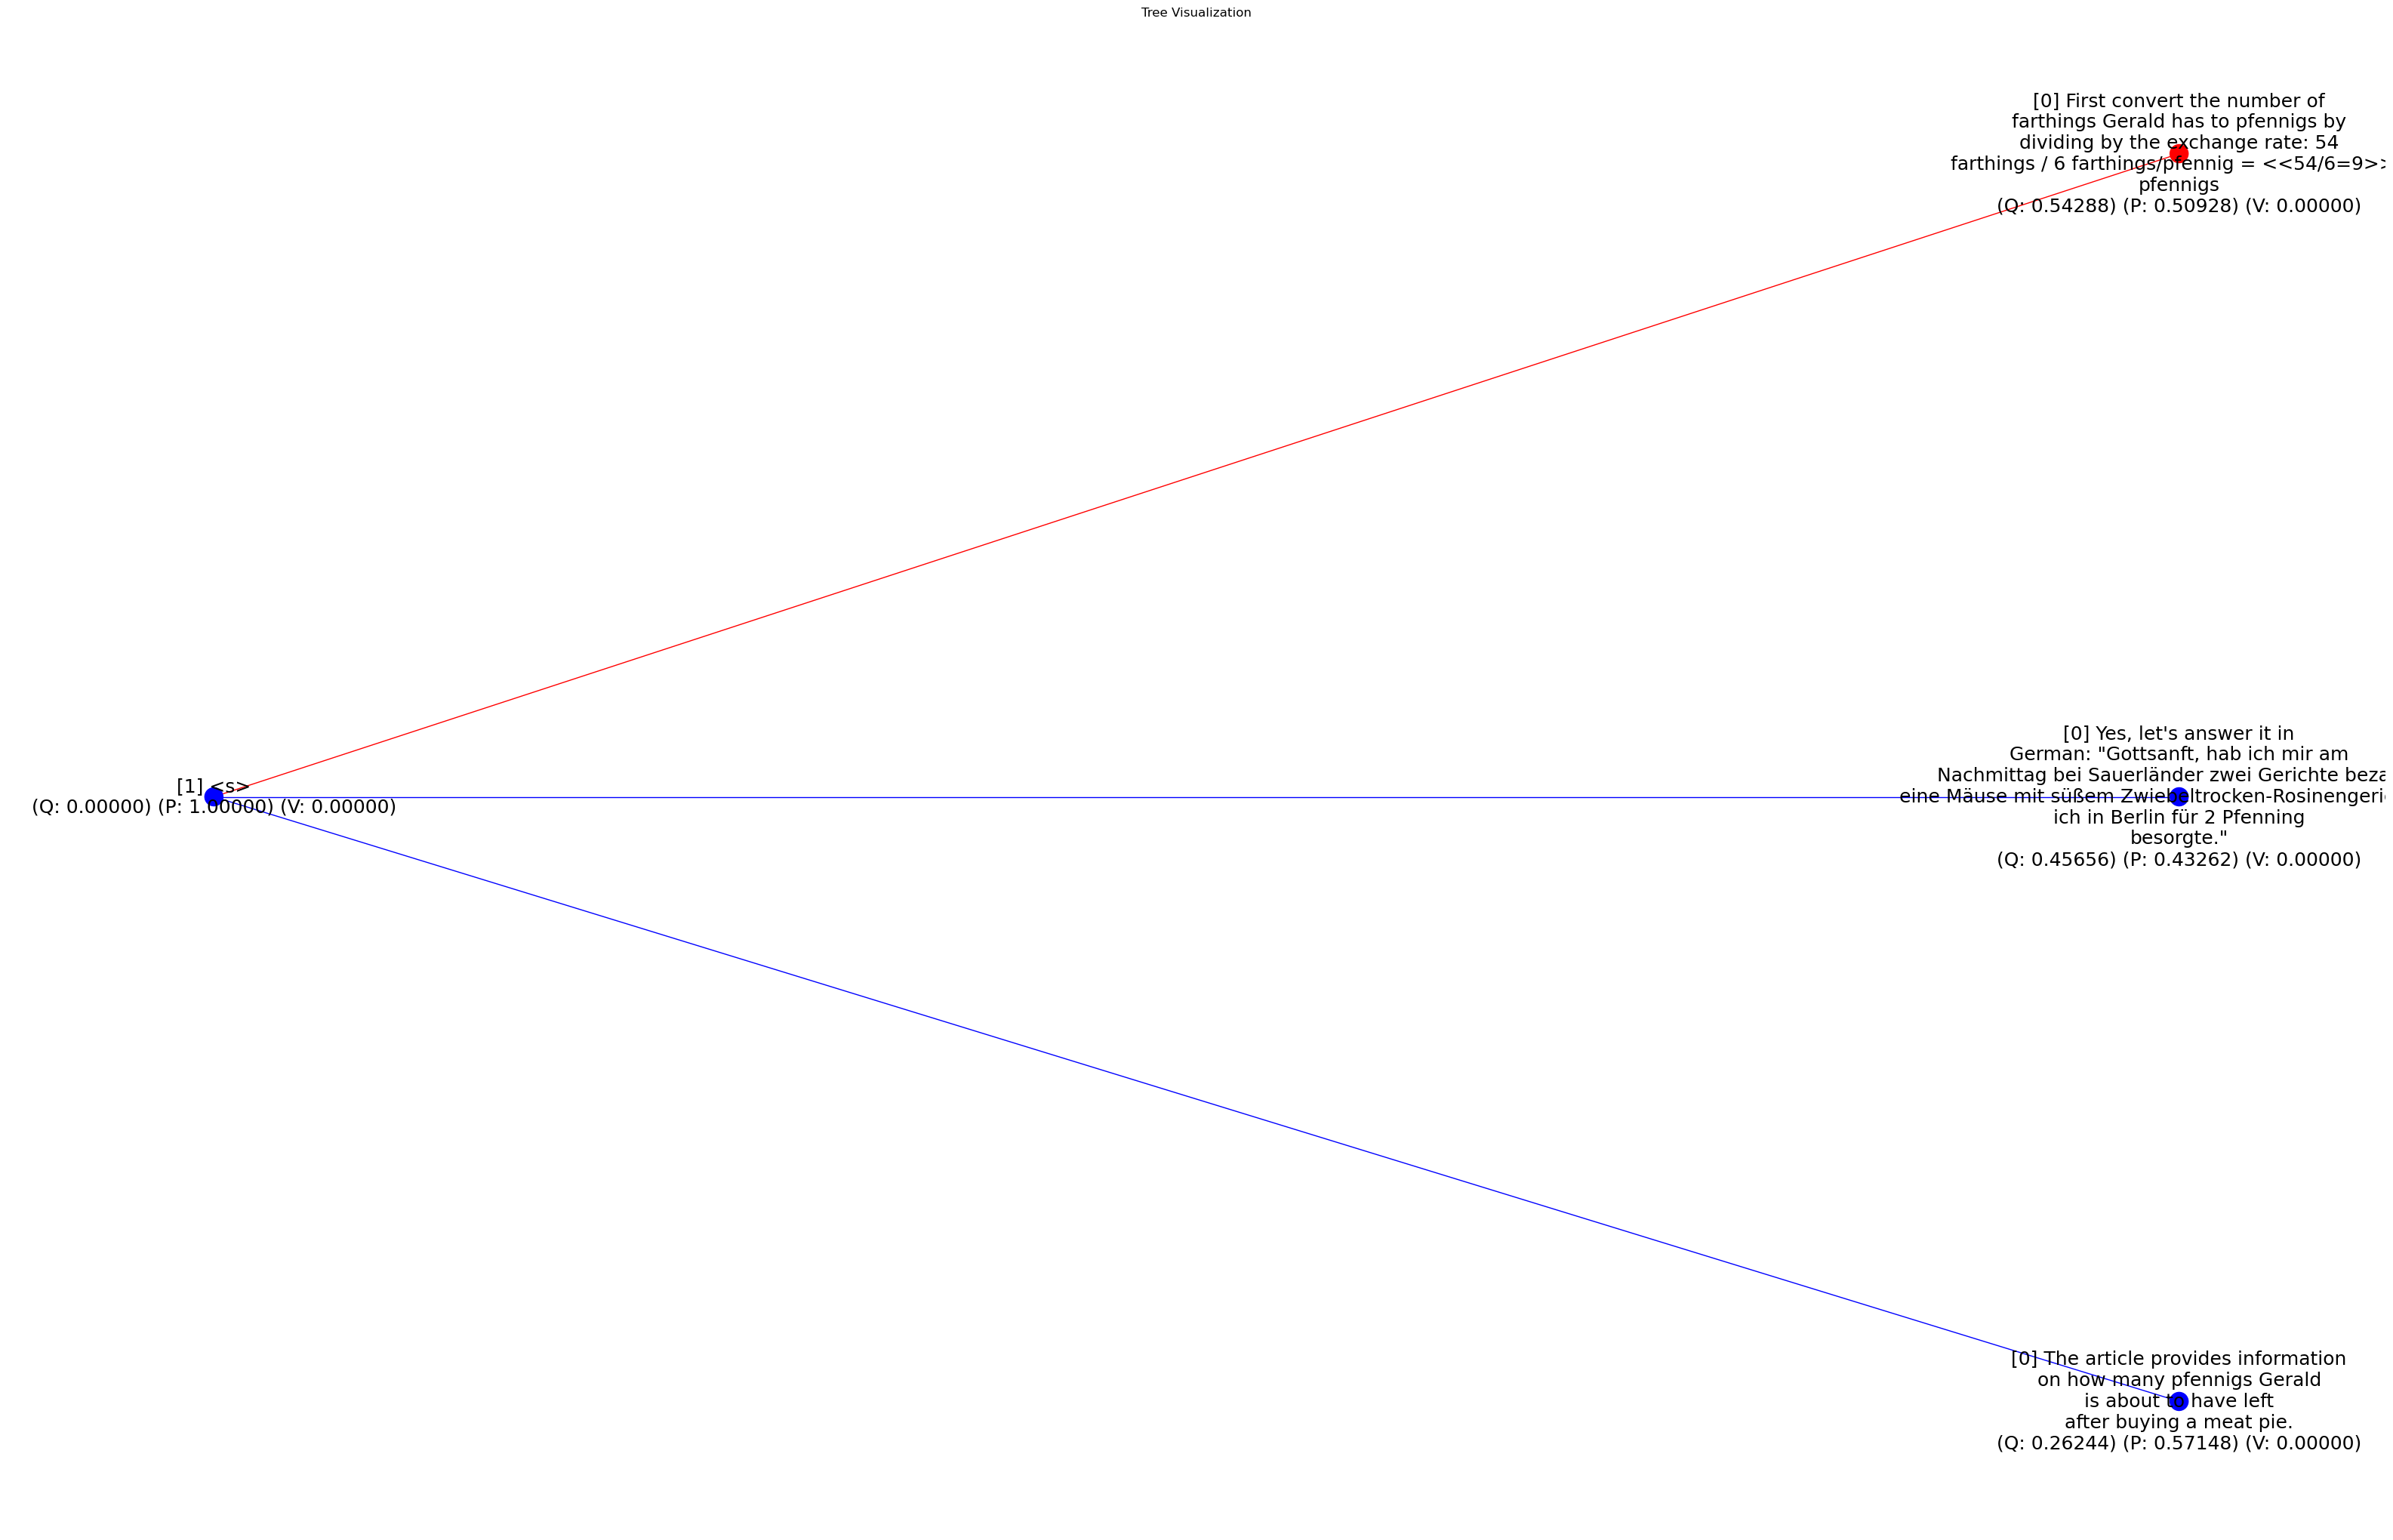

mcts_rst_3_bckp.pkl


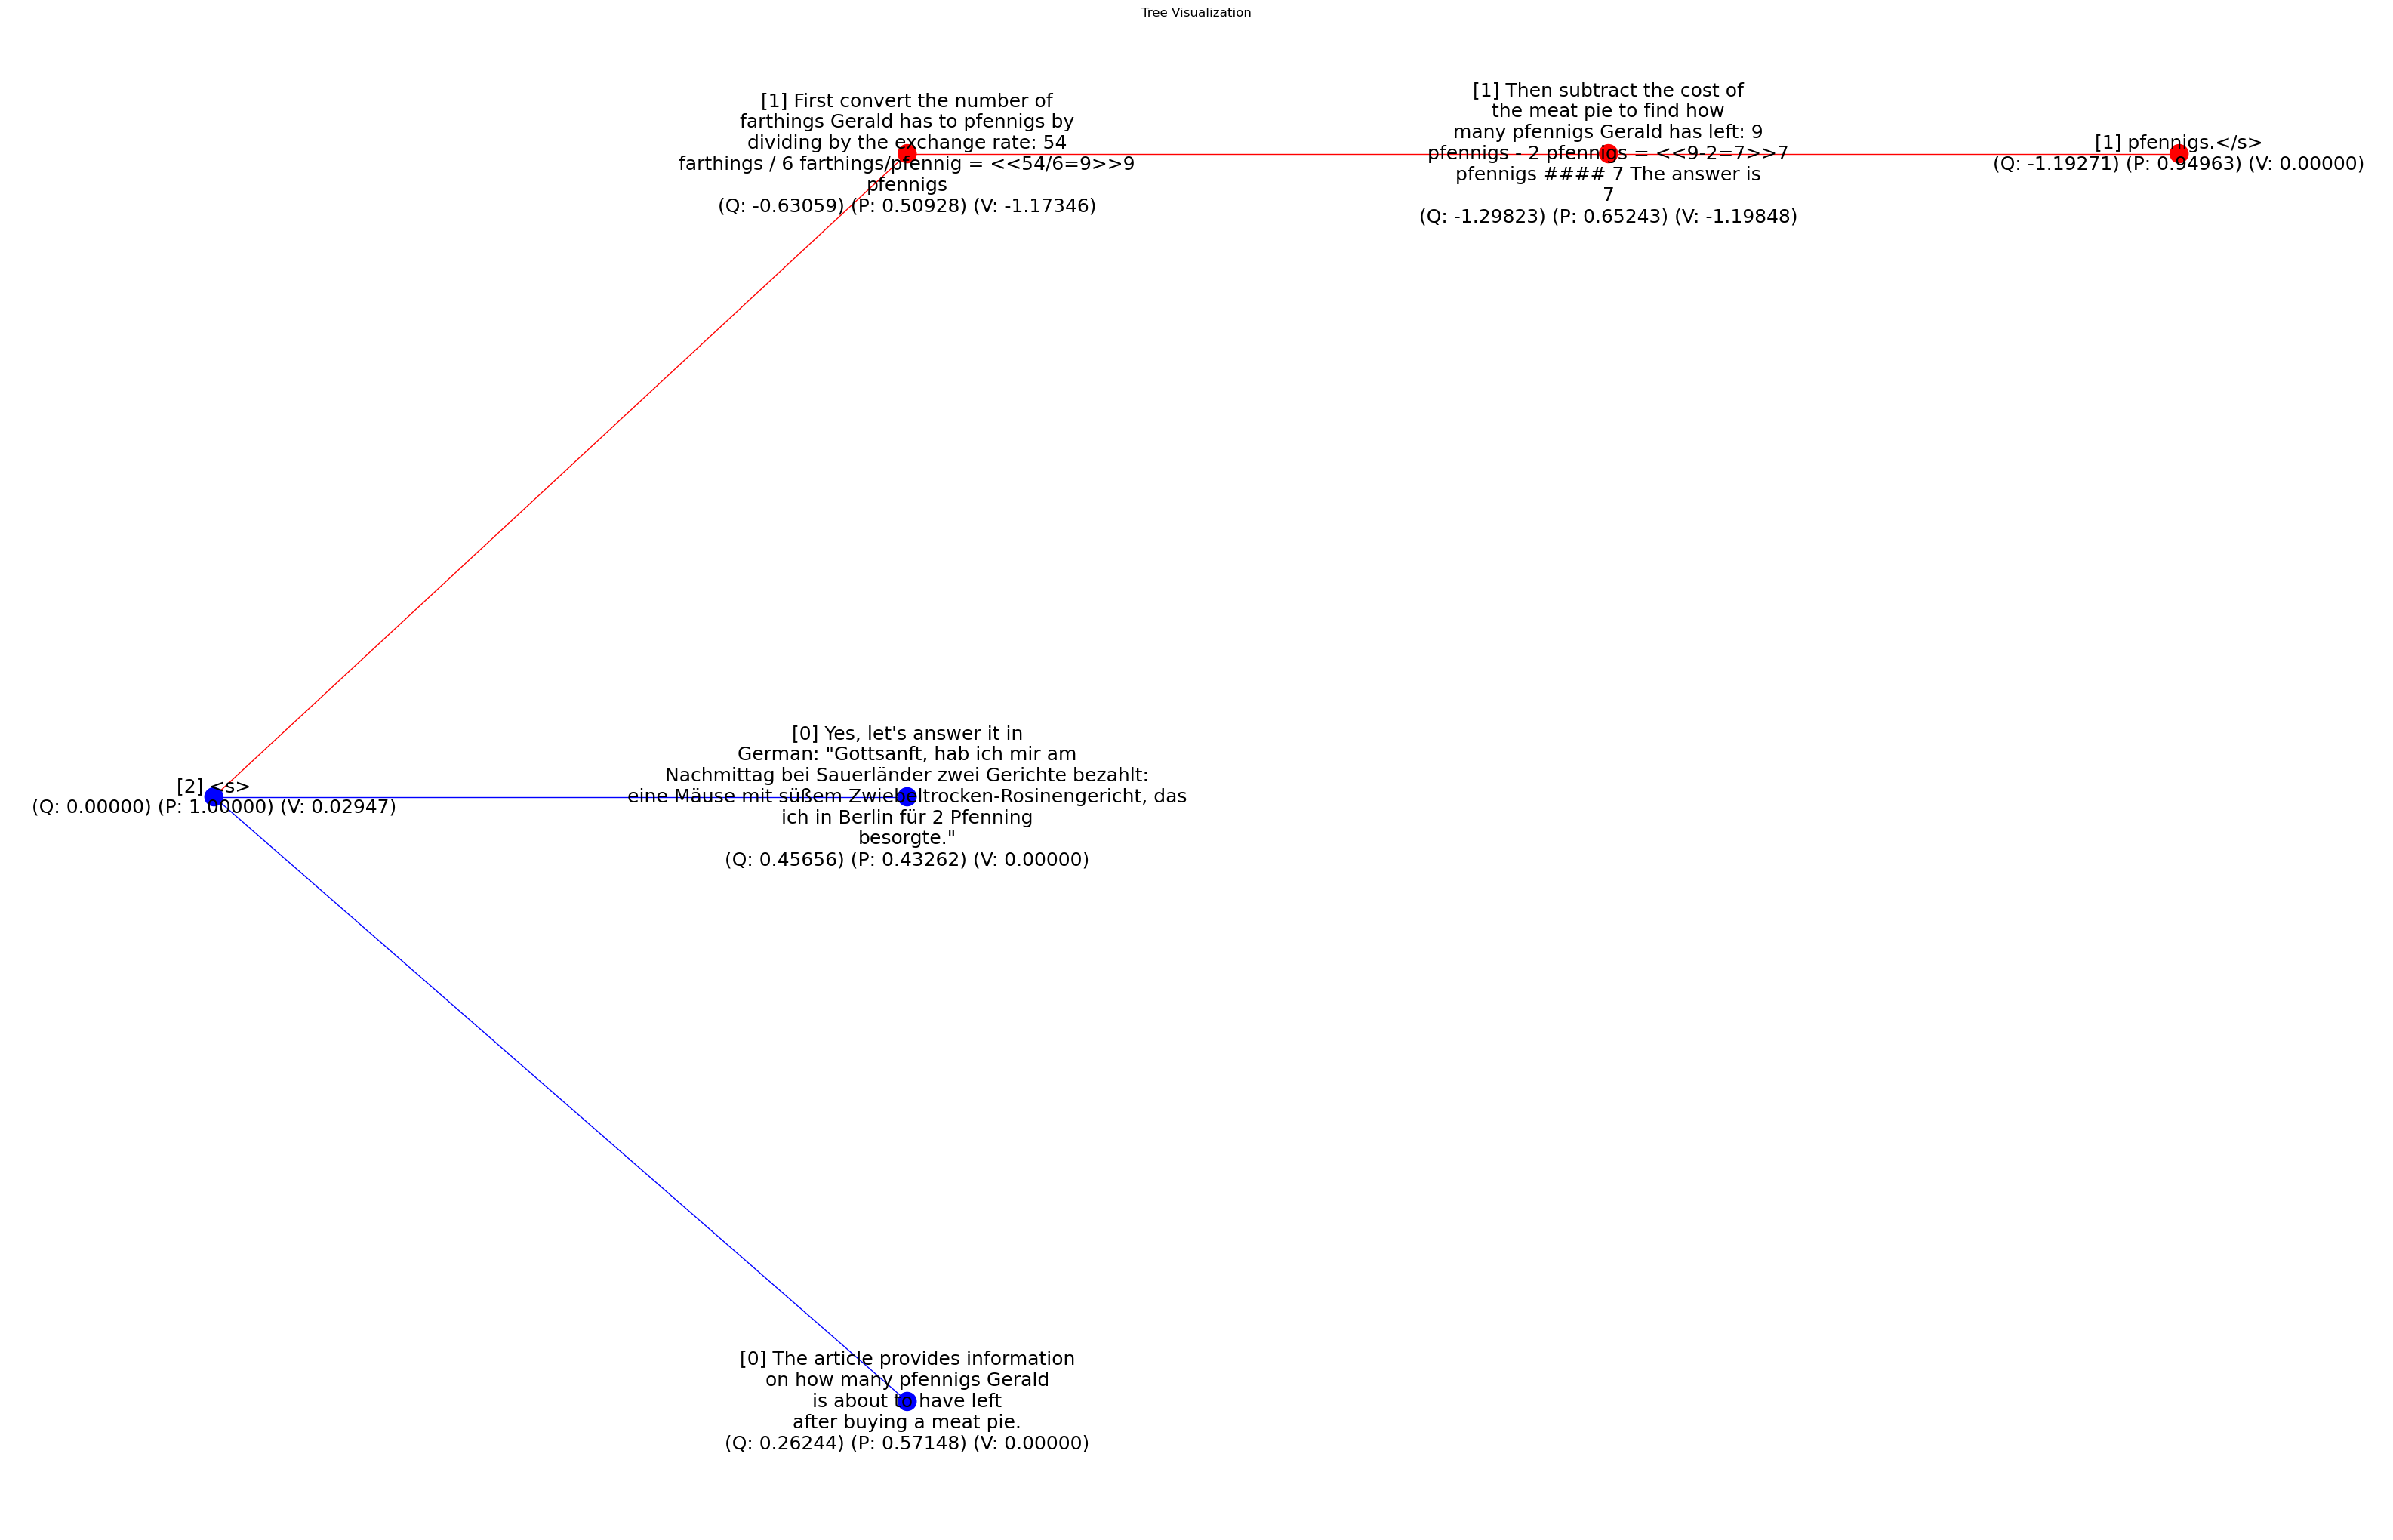

In [8]:
output_path = '/home/chalbeise/MCTS-DPO/MCTS-DPO/outputs/checkpoints/arithmetic/llama3-cdpo-2x2-gtsft/mcts_saved_trees'
iteration = 0
visualize_iteration_tree(output_path, iteration)

## Iteration 2